In [327]:
import numpy as np
import matplotlib.pyplot as plt


from qiskit.circuit import ParameterVector
from qiskit.opflow import X, Z, I, Y


from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator,
                                Sampler as RuntimeSampler,
                                Options)
from qiskit.primitives import Sampler,Estimator
from qiskit import *
from qiskit.visualization import *
from qiskit.algorithms.optimizers import COBYLA,NFT,GradientDescent,ADAM,SPSA
from qiskit.algorithms.minimum_eigensolvers import  VQE
from qiskit.circuit.library import EvolvedOperatorAnsatz,RXXGate,RZZGate

In [328]:
Id = np.array([[1, 0],
              [0, 1]])
X_pauli = np.array([[0, 1],
              [1, 0]])
Y_pauli = np.array([[0, -1j],
              [1j, 0]])
Z_pauli = np.array([[1, 0],
              [0, -1]])
H = np.array([[1, 1],
              [1, -1]]) / np.sqrt(2)
S = np.array([[1, 0],
              [0, 1j]])

CNOT01 = np.array([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 0, 1],
                   [0, 0, 1, 0]])
CNOT10 = np.array([[1, 0, 0, 0],
                   [0, 0, 0, 1],
                   [0, 0, 1, 0],
                   [0, 1, 0, 0]])
SWAP = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1]])

In [329]:
# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class QiskitVQE(MinimumEigensolver):
    
    def __init__(self,estimator, ansatz, optimizer,ham,initial_parameters=None,callback=None):
        self._estimator = estimator
        self._circuit = ansatz
        self._optimizer = optimizer
        self._callback = callback
        self._initial_parameters=initial_parameters
        self._obs=ham

        
    def compute_minimum_eigenvalue(self):
                
        # Define objective function to classically minimize over
        def objective(x):
            job = self._estimator.run(self._circuit,self._obs,[x])
            H=job.result().values[0]
            
            if self._callback is not None:
                self._callback([H,x])
            return H
            
        # Select an initial point for the ansatzs' parameters
        if self._initial_parameters is None:
            x0 = np.pi/2 * np.random.rand(self._circuit.num_parameters)
            
        else:
            x0=self._initial_parameters
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)

        job = self._estimator.run(self._circuit,self._obs,[res.x])
        H=job.result().values[0]

        return H

In [330]:
def two_qubits_Hamiltonian(E00,E10,E01,E11,Hx,Hz,l):
    H_0=np.array([[E00, 0, 0, 0],
                  [0, E10, 0, 0],
                  [0, 0, E01, 0],
                  [0, 0, 0, E11]])
    H_1= Hx*np.kron(X_pauli,X_pauli)+Hz*np.kron(Z_pauli,Z_pauli)
    
    return H_0+l*H_1

In [331]:
H=two_qubits_Hamiltonian(0,4,3,0.2,0.2,-3,1)
val,vecs=np.linalg.eigh(H)

In [332]:
def separable_ansatz(N_qubits,N_layers):
  theta = ParameterVector("m",2*N_qubits*N_layers)
  qr=QuantumRegister(N_qubits)
  qc=QuantumCircuit(qr)
  k=0
  for _ in range(N_layers):
    for i in range(N_qubits):
        qc.rx(theta[k],qr[i])
        k+=1
        qc.ry(theta[k],qr[i])
        k+=1

  return qc

In [333]:
def Efficient_ansatz(N_qubits,N_layers):
    theta = ParameterVector("m",4*N_qubits*N_layers)
    qr=QuantumRegister(N_qubits)
    qc=QuantumCircuit(qr)
    k=0
    for i in range (N_qubits):
            qc.rx(theta[k],qr[i])
            k+=1
            qc.ry(theta[k],qr[i])
            k+=1
    for i in range (N_qubits-1):
        qc.cx(qr[i],qr[i+1])
    for _ in range (N_layers-1):
        for i in range (N_qubits):
            qc.rx(theta[k],qr[i])
            k+=1
            qc.ry(theta[k],qr[i])
            k+=1
        for i in range (N_qubits-1):
            qc.cx(qr[i],qr[i+1])
        for i in range (N_qubits):
            qc.rx(theta[k],qr[i])
            k+=1
            qc.ry(theta[k],qr[i])
            k+=1
    return qc

In [334]:
def Real_ansatz(N_qubits,N_layers):
    theta = ParameterVector("theta",4*N_qubits*N_layers)
    qr=QuantumRegister(N_qubits)
    qc=QuantumCircuit(qr)
    k=0
    for i in range (N_qubits):

            qc.ry(theta[k],qr[i])
            k+=1
    for i in range (N_qubits-1):
        qc.cx(qr[i],qr[i+1])
    for _ in range (N_layers-1):
        for i in range (N_qubits):

            qc.ry(theta[k],qr[i])
            k+=1
        for i in range (N_qubits-1):
            qc.cx(qr[i],qr[i+1])
        for i in range (N_qubits):

            qc.ry(theta[k],qr[i])
            k+=1
    return qc

In [335]:
def Hamiltonian_ansatz(N_layers):
    theta = ParameterVector("theta",4*N_layers)
    qr=QuantumRegister(2)
    qc=QuantumCircuit(qr)
    k=0
    
    for i in range (2):
        qc.h(qr[i])
    
    for _ in range (N_layers):
        qc.rz(theta[k],qr[0])
        k+=1
        qc.rz(theta[k],qr[1])
        k+=1
        qc.cx(qr[0],qr[1])
        qc.rz(theta[k],qr[1])
        k+=1
        qc.rx(theta[k],qr[0])
        qc.rx(theta[k],qr[1])

        k+=1
        qc.cx(qr[0],qr[1])
    
    return qc

In [336]:
def Hamiltonian_ansatz(N_layers):
    theta = ParameterVector("theta",5*N_layers)
    qr=QuantumRegister(2)
    qc=QuantumCircuit(qr)
    k=0
    
    for i in range (2):
        qc.x(qr[i])
    for _ in range (N_layers):
        qc.rxx(theta[k],qr[0],qr[1])
        k+=1
        qc.rz(theta[k],qr[0])
        k+=1
        qc.rz(theta[k],qr[1])
        k+=1
        qc.rzz(theta[k],qr[0],qr[1])
        k+=1
    
    return qc

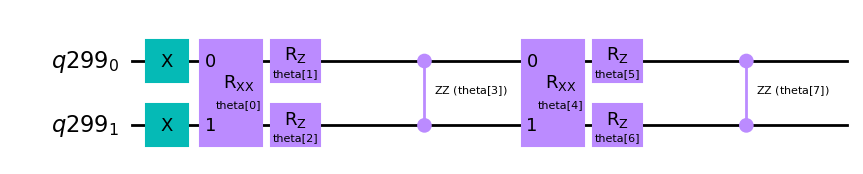

In [337]:
Hamiltonian_ansatz(2).draw(output='mpl')

In [338]:
from qiskit.opflow import PauliSumOp, SummedOp, PauliOp
def two_Hamiltonian_pauli(E00,E10,E01,E11,Hx,Hz,l):
    a=(E00+E01+E10+E11)/4
    b=a-(E01+E11)/2
    c=a-(E10+E11)/2
    d=a-(E10+E01)/2

    term1 = a * (I ^ I)
    term2 = b * (Z ^ I)
    term3 = c * (I ^ Z)
    term4 = d * (Z ^ Z)
    term5 = l*Hx * (X ^ X)
    term6 = l*Hz * (Z ^ Z)

    # Sum up all the terms
    H = SummedOp([term1, term2, term3, term4, term5, term6])
    
    return H

In [339]:
lambdas=np.arange(0.1,4/3,0.01)
vals_1=[]
vals_2=[]
vals_3=[]
vals_4=[]
for l in lambdas:
    H=two_qubits_Hamiltonian(0,2.5,6.5,7.0,2,3,l)
    val,vecs=np.linalg.eigh(H)
    vals_1.append(val[0])
    vals_2.append(val[1])
    vals_3.append(val[2])
    vals_4.append(val[3])

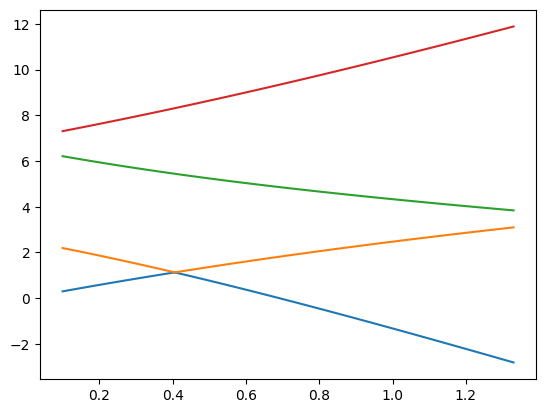

In [340]:
plt.plot(lambdas,vals_1)
plt.plot(lambdas,vals_2)
plt.plot(lambdas,vals_3)
plt.plot(lambdas,vals_4)

In [341]:
H=two_qubits_Hamiltonian(0,2.5,6.5,7.0,2,3,1)
val,vecs=np.linalg.eigh(H)

In [342]:
intermediate_info = []
def callback(data):
                intermediate_info.append(data)

# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator()

cobyla=COBYLA(maxiter=1000, disp=True, rhobeg=0.1, tol=0.01, options=None)
adam=ADAM(maxiter=300, tol=1e-02, lr=0.1, beta_1=0.9, beta_2=0.99, noise_factor=1e-10, eps=1e-10, amsgrad=True, snapshot_dir=None)
g_d=GradientDescent(maxiter=300,learning_rate=0.1, tol=0.001, callback=None, perturbation=None)
spsa=SPSA(maxiter=100, blocking=False, allowed_increase=None, trust_region=False, learning_rate=None, perturbation=None, last_avg=1, resamplings=1, perturbation_dims=None, callback=None)

In [343]:
ansatzs=[Real_ansatz(2,1),Efficient_ansatz(2,1),separable_ansatz(2,1)]
labels=['Real Amplitude Ansatz','Hardware Efficient Ansatz', 'Separable Ansatz']
infos=[]
for ans in ansatzs:
    intermediate_info= []
    initial_parameters=np.ones(ans.num_parameters)*np.pi/2
    estimator = Estimator(options={'shots': None})
    H=two_Hamiltonian_pauli(0,2.5,6.5,7.0,2,3,1).reduce()
    custom_vqe = QiskitVQE(estimator,ans,cobyla,H,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)

C:\Users\rubenb\AppData\Local\Temp\ipykernel_11792\2507913928.py:16: DeprecationWarning: The class ``qiskit.opflow.list_ops.summed_op.SummedOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  H = SummedOp([term1, term2, term3, term4, term5, term6])


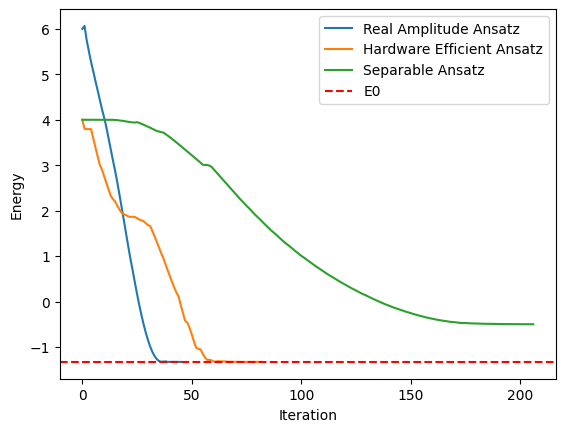

In [344]:
def callback(data):
                intermediate_info.append(data)
for i,opt_info in enumerate(infos):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val[0], color='r', linestyle='--',label='E0')
plt.legend()
plt.show()

In [345]:
ansatzs=[separable_ansatz(2,1),separable_ansatz(2,2),separable_ansatz(2,3),separable_ansatz(2,4)]
labels=['depth 1','depth 2','depth 3', 'depth 4']
infos=[]
for ans in ansatzs:
    intermediate_info= []
    initial_parameters=np.ones(ans.num_parameters)*np.pi/2
    estimator = Estimator(options={'shots': None})
    H=two_Hamiltonian_pauli(0,2.5,6.5,7.0,2,3,1).reduce()
    custom_vqe = QiskitVQE(estimator,ans,cobyla,H,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)

C:\Users\rubenb\AppData\Local\Temp\ipykernel_11792\2507913928.py:16: DeprecationWarning: The class ``qiskit.opflow.list_ops.summed_op.SummedOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  H = SummedOp([term1, term2, term3, term4, term5, term6])


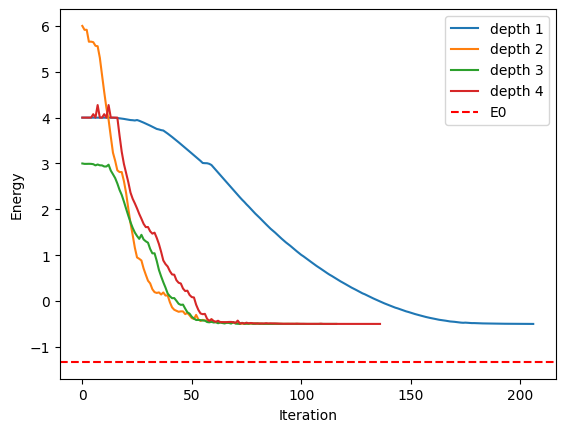

In [346]:
def callback(data):
                intermediate_info.append(data)
for i,opt_info in enumerate(infos):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val[0], color='r', linestyle='--',label='E0')
plt.legend()
plt.show()

In [347]:
ansatzs=[Real_ansatz(2,1),Real_ansatz(2,2),Real_ansatz(2,3),Real_ansatz(2,4)]
labels=['depth 1','depth 2','depth 3', 'depth 4']
infos=[]
for ans in ansatzs:
    intermediate_info= []
    initial_parameters=np.ones(ans.num_parameters)*np.pi/2
    estimator = Estimator(options={'shots': None})
    H=two_Hamiltonian_pauli(0,2.5,6.5,7.0,2,3,1).reduce()
    custom_vqe = QiskitVQE(estimator,ans,cobyla,H,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)

C:\Users\rubenb\AppData\Local\Temp\ipykernel_11792\2507913928.py:16: DeprecationWarning: The class ``qiskit.opflow.list_ops.summed_op.SummedOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  H = SummedOp([term1, term2, term3, term4, term5, term6])


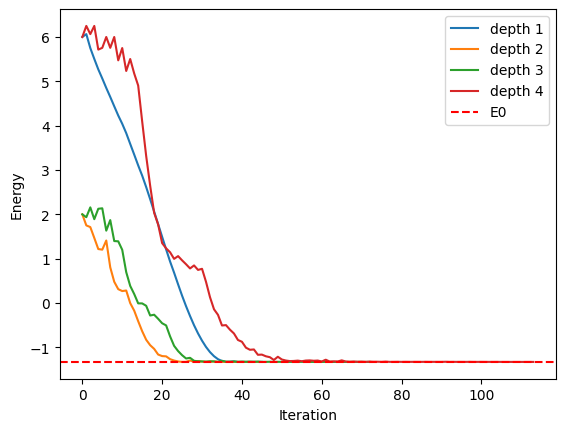

In [348]:
def callback(data):
                intermediate_info.append(data)
for i,opt_info in enumerate(infos):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val[0], color='r', linestyle='--',label='E0')
plt.legend()
plt.show()

In [349]:
ansatzs=[Efficient_ansatz(2,1),Efficient_ansatz(2,2),Efficient_ansatz(2,3),Efficient_ansatz(2,4)]
labels=['depth 1','depth 2','depth 3', 'depth 4']
infos=[]
for ans in ansatzs:
    intermediate_info= []
    initial_parameters=np.ones(ans.num_parameters)*np.pi/2
    estimator = Estimator(options={'shots': None})
    H=two_Hamiltonian_pauli(0,2.5,6.5,7.0,2,3,1).reduce()
    custom_vqe = QiskitVQE(estimator,ans,cobyla,H,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)

C:\Users\rubenb\AppData\Local\Temp\ipykernel_11792\2507913928.py:16: DeprecationWarning: The class ``qiskit.opflow.list_ops.summed_op.SummedOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  H = SummedOp([term1, term2, term3, term4, term5, term6])


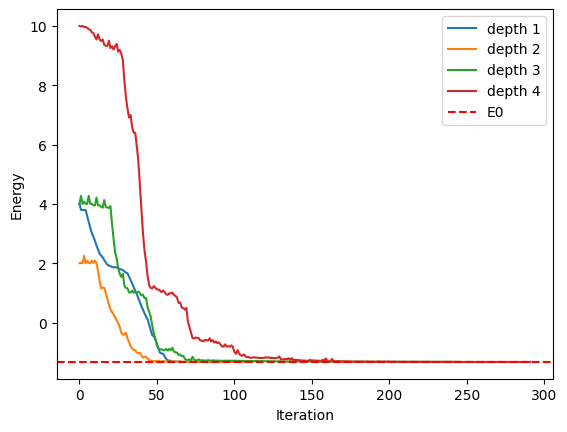

In [350]:
def callback(data):
                intermediate_info.append(data)
for i,opt_info in enumerate(infos):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val[0], color='r', linestyle='--',label='E0')
plt.legend()
plt.show()

In [374]:
gs_real=[]
gs_eff=[]
gs_sep=[]
optimizer=cobyla
lambdas=np.arange(0.01,4/3,4/30)

ansatzs=[Real_ansatz(2,2),Efficient_ansatz(2,2),separable_ansatz(2,2)]
initial_parameters=[np.ones(ansatzs[0].num_parameters)*np.pi/2,np.ones(ansatzs[1].num_parameters)*np.pi/2,np.ones(ansatzs[2].num_parameters)*np.pi/2]
for l in lambdas:
    intermediate_info= []
    
    estimator = Estimator(options={'shots': None})
    H=two_Hamiltonian_pauli(0,2.5,6.5,7.0,2,3,l).reduce()
    
    custom_vqe = QiskitVQE(estimator,ansatzs[0],optimizer,H,initial_parameters=initial_parameters[0],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_real.append(result)

    
    custom_vqe = QiskitVQE(estimator,ansatzs[1],optimizer,H,initial_parameters=initial_parameters[1],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_eff.append(result)


    custom_vqe = QiskitVQE(estimator,ansatzs[2],optimizer,H,initial_parameters=initial_parameters[2],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_sep.append(result)

C:\Users\rubenb\AppData\Local\Temp\ipykernel_11792\2507913928.py:16: DeprecationWarning: The class ``qiskit.opflow.list_ops.summed_op.SummedOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  H = SummedOp([term1, term2, term3, term4, term5, term6])


In [382]:
gs_real=[]
gs_eff=[]
gs_sep=[]
optimizer=spsa
lambdas=np.arange(0.01,4/3,4/30)

ansatzs=[Real_ansatz(2,2),Efficient_ansatz(2,2),separable_ansatz(2,2)]
initial_parameters=[np.ones(ansatzs[0].num_parameters)*np.pi/2,np.ones(ansatzs[1].num_parameters)*np.pi/2,np.ones(ansatzs[2].num_parameters)*np.pi/2]
for l in lambdas:
    intermediate_info= []
    
    estimator = Estimator(options={'shots': 10000})
    H=two_Hamiltonian_pauli(0,2.5,6.5,7.0,2,3,l).reduce()
    
    custom_vqe = QiskitVQE(estimator,ansatzs[0],optimizer,H,initial_parameters=initial_parameters[0],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_real.append(result)

    
    custom_vqe = QiskitVQE(estimator,ansatzs[1],optimizer,H,initial_parameters=initial_parameters[1],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_eff.append(result)


    custom_vqe = QiskitVQE(estimator,ansatzs[2],optimizer,H,initial_parameters=initial_parameters[2],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_sep.append(result)

C:\Users\rubenb\AppData\Local\Temp\ipykernel_11792\2507913928.py:16: DeprecationWarning: The class ``qiskit.opflow.list_ops.summed_op.SummedOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  H = SummedOp([term1, term2, term3, term4, term5, term6])


In [383]:
lambdas_ex=np.arange(0.001,4/3,0.01)
vals_1=[]
vals_2=[]
vecs_1=[]
vecs_2=[]
for l in lambdas_ex:
    H=two_qubits_Hamiltonian(0,2.5,6.5,7.0,2,3,l)
    val,vecs=np.linalg.eigh(H)
    vals_1.append(val[0])
    vals_2.append(val[1])

In [384]:
gs_real

[0.02992393884791748,
 0.4200219008451352,
 1.5719758675409579,
 1.1266324335945208,
 1.4545450582651323,
 0.055192576931191534,
 -0.5039300053680138,
 -1.0793596010700564,
 -1.6685423212925106,
 -2.2699721122745937]

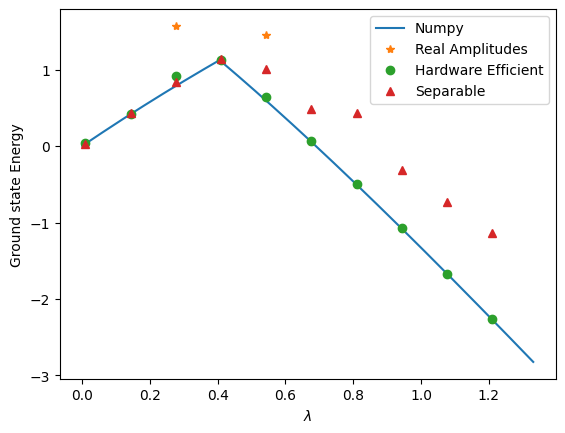

In [386]:
plt.plot(lambdas_ex,vals_1,label='Numpy')
plt.plot(lambdas,gs_real,linestyle='',marker='*',label='Real Amplitudes')
plt.plot(lambdas,gs_eff,linestyle='',marker='o',label='Hardware Efficient')
plt.plot(lambdas,gs_sep,linestyle='',marker='^',label='Separable')
plt.xlabel(r'$\lambda$')
plt.ylabel('Ground state Energy')
plt.legend()
plt.show()